# Pre-Training a Large Language Model like GPT2

A toy example based on the video by Andrej Kaparthy https://www.youtube.com/watch?v=kCc8FmEb1nY&t=11s. Here I train and compare several architectures discussed during the lecture.

https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=hoelkOrFY8bN

In [1]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv("../../.env")
huggingface_token = os.environ["HUGGINGFACE_TOKEN"]
login(token=huggingface_token)

/home/rubenbalbastre/Escritorio/Repositorios/LLM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Data

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2026-01-09 11:55:38--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.110.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 1115394 (1,1M) [text/plain]
Guardando como: ‘input.txt.1’

input.txt.1         100%[===================>]   1,06M  --.-KB/s    en 0,1s    

2026-01-09 11:55:39 (9,72 MB/s) - ‘input.txt.1’ guardado [1115394/1115394]



## Tokenize the data

Tokenization is done at character level instead of token level for learning purposes

In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

torch.Size([1115394]) torch.int64


## Dataset Splits: training & validation

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Prepare Data Batches

In [56]:
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

In [57]:
import torch 
torch.manual_seed(1337)

def get_batch(split, block_size=block_size, batch_size=batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train', block_size=block_size, batch_size=batch_size)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


## Models

### Bigram Model

We assume the next token (at time t+1) only the depends on the last token (at time t). For this, we use a simple embedding layer which acts as a learnable vector mapping.

#### Definition

In [86]:
import torch
import torch.nn as nn 
from torch.nn import functional as F
torch.manual_seed(1333)


def compute_loss(logits, targets):
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits, targets)
    return loss


class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # Vocab Size, Channel

    def forward(self, x):
        logits = self.token_embedding_table(x) # (B,T,C)
        return logits

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits = m(xb)
loss = compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.4733, grad_fn=<NllLossBackward0>)


In [70]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Jv
&H?JZDB.RNbfuJb.R$
; n
SihyVKJZNnAH:ZNL,C.CBJ;rKrbVP-?dhgUdk3Ea;XKgd$D-WgdoPAaza.PAalt!IPdMcb?Kjw


#### Training

In [73]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            loss = compute_loss(logits, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

In [87]:
batch_size = 32
n_steps = 2000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

losses_record = []
for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Bigram'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.6380, val loss 4.6334
step 200: train loss 4.5197, val loss 4.5001
step 400: train loss 4.3594, val loss 4.3893
step 600: train loss 4.2537, val loss 4.2303
step 800: train loss 4.1315, val loss 4.1169
step 1000: train loss 4.0059, val loss 4.0020
step 1200: train loss 3.8720, val loss 3.8906
step 1400: train loss 3.8110, val loss 3.7995
step 1600: train loss 3.6899, val loss 3.7015
step 1800: train loss 3.5963, val loss 3.6172
step 1999: train loss 3.5258, val loss 3.5388


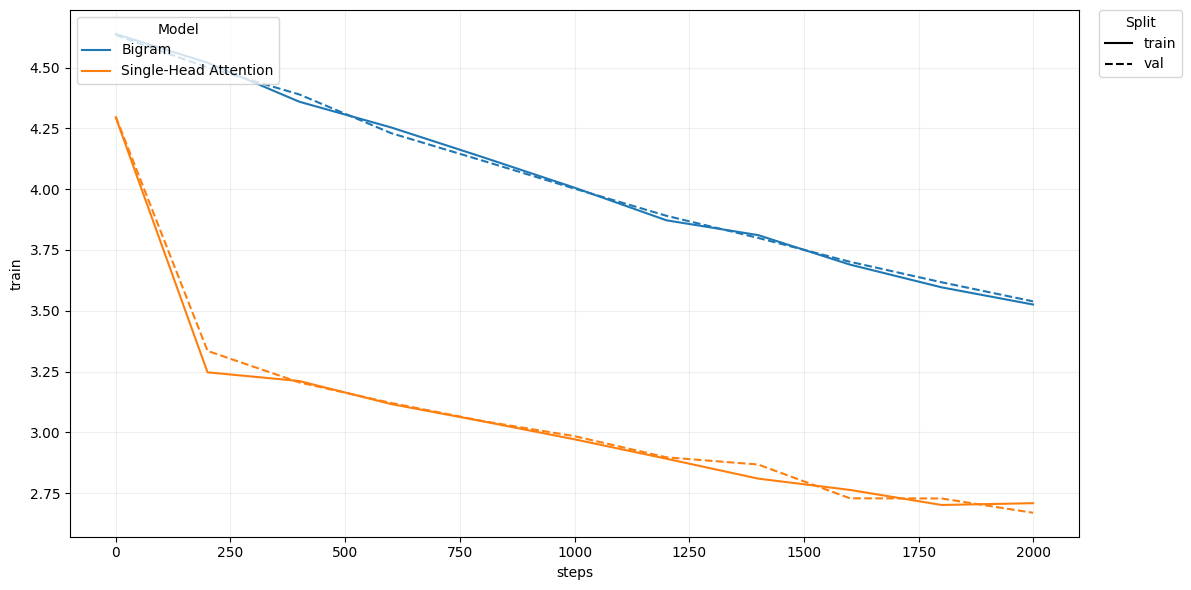

In [99]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_losses(losses_df):

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.lineplot(data=losses_df, x="steps", y="train", hue="model", ax=ax)
    sns.lineplot(data=losses_df, x="steps", y="val",   hue="model", linestyle="--", ax=ax, legend=False)

    ax.grid(alpha=0.2)

    # Seaborn's model legend (keep it inside)
    legend1 = ax.legend(title="Model", loc="upper left")
    ax.add_artist(legend1)

    # Custom linestyle legend (place it outside)
    style_legend = [
        Line2D([0], [0], color="black", linestyle="-",  label="train"),
        Line2D([0], [0], color="black", linestyle="--", label="val"),
    ]
    ax.legend(
        handles=style_legend,
        title="Split",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),   # just outside the right edge
        borderaxespad=0.0,
        frameon=True
    )

    plt.tight_layout()
    plt.show()

plot_losses(losses_df)

In [64]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


MzPVAXU.VoGdyPA:AQCLoIfceNB.RsLCPSoce sqyOpLS
MliJnepo th&VOitMZN$buM?goubbS&ZJTbe?go'A zO'AXH$ Cumnos, e sw&w kncthqFNCoj;An
SzDtnj-,
-':3UoErr FBlttjKUthTherthXup;
mmIL.bS&FepMXBolBKbS-,;LOs tD-'eQfoutLgi?VUh!:weF
CG?fc
iuTt?Ik' aEw'soEalck3LS k3PIH--gkit.RLoH.w-KJ
bSnVh.KlFNKzse3V.l,?eR;QLwe aveBo pantlaNXRYekDhy:kDGE yre;iJndVit el-f.CG tDIqQyMY
N?pVnpL:klJ f fLerXgitHgTMlfrerTzcp'ubSQLW!UdTMWl&no?ny;Lp!r.Ml;'R&.R3?;
M
H.tUomyM$drxQFJ,
Selom nvpdous&?zazpCgy:i
:Ce
Sobl zgqGLthEx;
QOsceJAeZea


### Single-Head Attention Model

#### Definition

In [90]:
class AttentionHead(nn.Module):

    def __init__(self, head_size, n_embedding):
        super().__init__()
        self.n_embedding = n_embedding
        self.key = nn.Linear(n_embedding, head_size, bias=False)
        self.value = nn.Linear(n_embedding, head_size, bias=False)
        self.query = nn.Linear(n_embedding, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        q = self.query(x)
        v = self.value(x)
        k = self.key(x)

        wei = q @ k.transpose(-2,-1) * self.n_embedding**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        attention = F.softmax(wei, dim=-1) @ v
        return attention
    

class SingleHeadAttentionModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.self_attention = AttentionHead(n_embedding=n_embedding, head_size=n_embedding//2)
        self.linear = nn.Linear(n_embedding//2, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.self_attention(embeddings)
        out = self.linear(attention)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
m = SingleHeadAttentionModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding)
logits = m(xb)
loss = compute_loss(logits, yb)
print(logits.shape)

torch.Size([4, 8, 65])


In [83]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


vc
wU,3Y-dWArNWprIYE;aOsJsAFsI! obdpFE'Arfb3:inz$DHm!w&QH3YnWS
cRaAA;E.Zam;jHnBhmjNZ mTcLNeLZDyEFHMd


#### Training

In [91]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
n_steps = 2000

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Single-Head Attention'
        losses['steps'] = steps
        losses_record.append(losses)


    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


step 0: train loss 4.2951, val loss 4.2979
step 200: train loss 3.2470, val loss 3.3350
step 400: train loss 3.2114, val loss 3.2056
step 600: train loss 3.1167, val loss 3.1211
step 800: train loss 3.0457, val loss 3.0467
step 1000: train loss 2.9716, val loss 2.9845
step 1200: train loss 2.8920, val loss 2.8977
step 1400: train loss 2.8101, val loss 2.8681
step 1600: train loss 2.7636, val loss 2.7293
step 1800: train loss 2.7018, val loss 2.7285
step 1999: train loss 2.7092, val loss 2.6697
2.5400924682617188


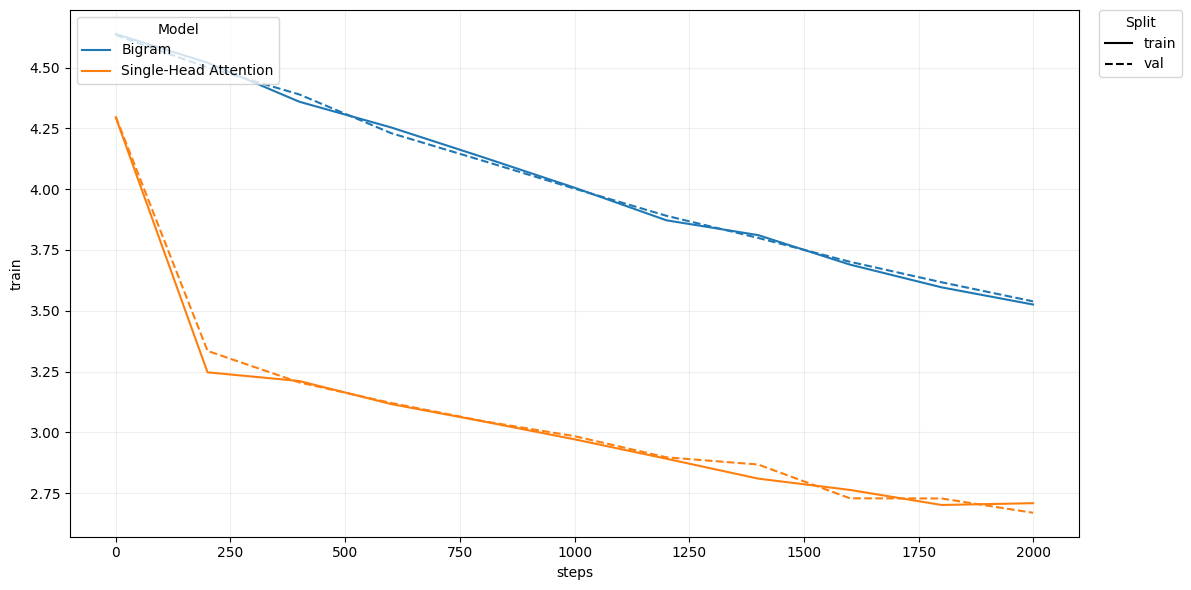

In [ ]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)

### Multi-Head Self-Attention Model

#### Definition

In [104]:
class MultiAttentionHead(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        head_size = n_embedding//n_heads
        self.heads = nn.ModuleList([AttentionHead(n_embedding=n_embedding, head_size=head_size) for _ in range(n_heads)])
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out
    

class MultiHeadAttentionModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding, n_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.multiple_self_attention = MultiAttentionHead(n_embedding=n_embedding, n_heads=n_heads)
        self.linear = nn.Linear(n_embedding, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.multiple_self_attention(embeddings)
        out = self.linear(attention)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
n_heads = 4
m = MultiHeadAttentionModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding, n_heads=n_heads)
logits = m(xb)
print(logits.shape)

torch.Size([4, 8, 65])


#### Training

In [105]:
batch_size = 32
n_steps = 2000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Multi-Head Attention'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.2223, val loss 4.2276
step 200: train loss 3.2250, val loss 3.2008
step 400: train loss 2.9872, val loss 3.0476
step 600: train loss 2.9241, val loss 2.9253
step 800: train loss 2.8273, val loss 2.7891
step 1000: train loss 2.7391, val loss 2.7742
step 1200: train loss 2.7301, val loss 2.7299
step 1400: train loss 2.6957, val loss 2.6765
step 1600: train loss 2.6482, val loss 2.6588
step 1800: train loss 2.5991, val loss 2.6408
step 1999: train loss 2.5945, val loss 2.6152


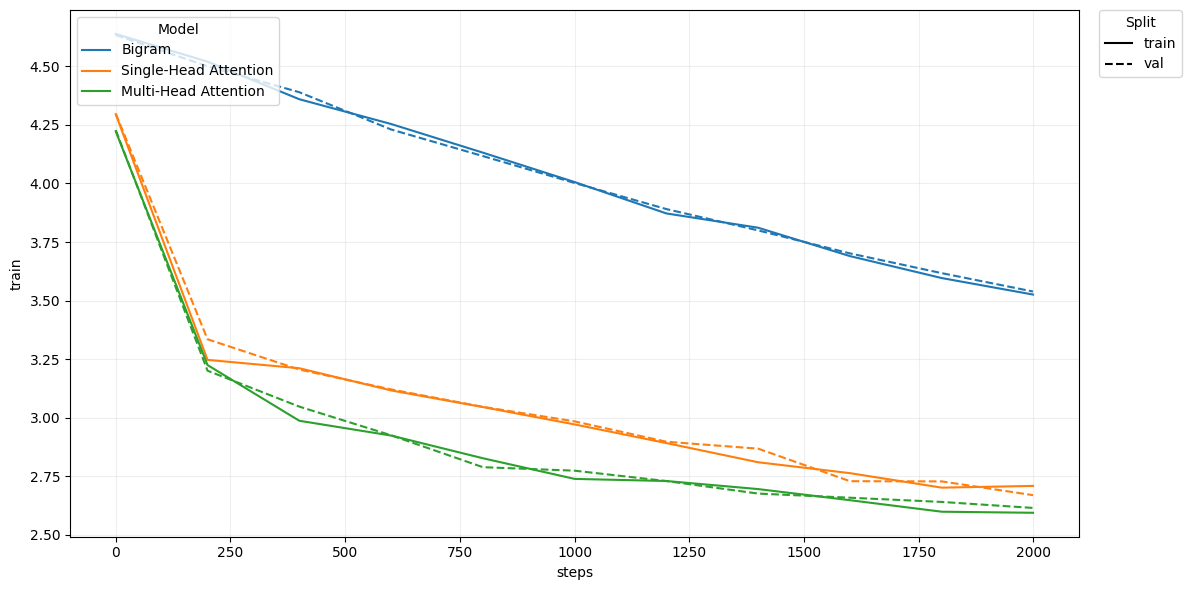

In [106]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)

In [107]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


IMONTEO Y:B, olwatank vorls bely lady amrikhemici inghannd harens.

NE:
O
CCEPSIAWoE rn soryt, bw or


### GPT-2 Model

#### Definition

#### Training

## The mathematical trick in self-attention

In [15]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [16]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [17]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [18]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

False

In [19]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

False

In [20]:
tril 

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [21]:
wei 

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [22]:
# v4 self-attention

B, T, C = 4, 8, 32
x = torch.randn(B, T, C)
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # B, T, 16
q = query(x) # B, T, 16
v = value(x) # B, T, 16

wei = q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, 16) x (B, 16, T) --> (B, T, T)
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei.shape

torch.Size([4, 8, 8])

In [23]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5124, 0.4876, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2361, 0.2073, 0.5566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2141, 0.1465, 0.5219, 0.1175, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1772, 0.1684, 0.2309, 0.2516, 0.1720, 0.0000, 0.0000, 0.0000],
        [0.1318, 0.1948, 0.1391, 0.1463, 0.1958, 0.1923, 0.0000, 0.0000],
        [0.1356, 0.0573, 0.4062, 0.0976, 0.1091, 0.1435, 0.0507, 0.0000],
        [0.1083, 0.1771, 0.0855, 0.1267, 0.1177, 0.2036, 0.0867, 0.0944]],
       grad_fn=<SelectBackward0>)

In [24]:
out = wei @ v # (B, T, T) x (B, T, T) --> (B, T, T)
out.shape 

torch.Size([4, 8, 16])